In [15]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

In [17]:
def create_pd(train_path,test_path):
    train=pd.read_csv(train_path)
    test=pd.read_csv(test_path)
    train.columns=[x for x in range(188)]
    test.columns=[x for x in range(188)]
    return pd.concat([train,test], axis=0, join='inner').sort_index()
    

In [18]:
mit_train_path="../input/heartbeat/mitbih_train.csv"
mit_test_path="../input/heartbeat/mitbih_test.csv"

In [19]:
mit= create_pd(mit_train_path,mit_test_path)
mit.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
def create_k_folds_column(df):
    df.loc[:,'kfold']=-1
    df=df.sample(frac=1).reset_index(drop=True)
    y=df.loc[:,187].values
    kf=StratifiedKFold(n_splits=5)
    for fold,(target,index) in enumerate(kf.split(X=df,y=y)):
        df.loc[index,'kfold']=fold
    return df
    

In [22]:
mit= create_k_folds_column(mit)

The MITBIH dataset is constituted of 109446 beats, labeled with 5 different classes :

'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4

N : Non-ecotic beats (normal beat) 

S : Supraventricular ectopic beats 

V : Ventricular ectopic beats

F : Fusion Beats 

Q : Unknown Beats

The PTBHB dataset is constituted of 14552 beats, labeled with two different classes :

'0' for normal beat
'1' for abnormal beat (Myocardial infarction)

All the beats are recorded with 187 points. The shorter beats are padded with zeros to reach 187.

In [23]:
mit.head()

,0,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,187,kfold
0,1.000000,0.659794,0.068729,0.099656,0.195876,0.182131,0.147766,0.137457,0.140893,0.147766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.000000,0.941909,0.468880,0.338174,0.327801,0.325726,0.259336,0.230290,0.178423,0.139004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.000000,0.739535,0.316279,0.058915,0.000000,0.103876,0.139535,0.103876,0.105426,0.106977,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.077519,0.067183,0.095607,0.162791,0.258398,0.317829,0.330749,0.361757,0.418605,0.490956,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
4,1.000000,0.955556,0.490370,0.000000,0.013333,0.189630,0.241481,0.213333,0.217778,0.232593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [24]:
mit.loc[:,187].astype('int').value_counts()

0    90587
4     8039
2     7236
1     2779
3      803
Name: 187, dtype: int64

Defining the model

In [57]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout,MaxPooling1D,GlobalAveragePooling1D
from tensorflow.keras import Model, layers,Sequential,regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [45]:
def make_model(X_train):
    model= Sequential()
    model.add(Convolution1D(32,5,activation='relu',input_shape=(187,1)))
    model.add(Convolution1D(64,5,activation='relu'))         
    model.add(MaxPooling1D(3))
    model.add(Convolution1D(128, 3, activation='relu'))
    model.add(Convolution1D(256, 3, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(5,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])
    return model



In [46]:
def training_data(train,valid):
    X_train=np.asarray(train.iloc[:,:187].values)
    y_train=train.iloc[:,187].values
    X_valid=np.asarray(valid.iloc[:,:187].values)
    y_valid=valid.iloc[:,187].values
    X_train=tf.expand_dims(X_train, axis=2)
    X_valid=tf.expand_dims(X_valid, axis=2)
    y_train=to_categorical(y_train)
    y_valid=to_categorical(y_valid)
    return X_train,y_train,X_valid,y_valid

**Fitting the model**

In [98]:
Epochs=100
Batch_size=64
my_callbacks = [EarlyStopping(patience=3,monitor='val_loss', mode='min',restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=2, min_lr=0.00001, mode='auto')]
dict_acc={}
dict_acc2={}

In [51]:
def run_train(fold):
    train=mit[mit["kfold"]!=fold].reset_index(drop=True)
    valid=mit[mit["kfold"]==fold].reset_index(drop=True)
    X_train,y_train,X_valid,y_valid=training_data(train,valid)
    model=make_model(X_train)
    history = model.fit(X_train,y_train,validation_split=0.1,batch_size=Batch_size,epochs=Epochs,callbacks=my_callbacks)
    model.save(f'model{fold}.h5')
    results = model.evaluate(X_valid, y_valid)
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    print("     Test AUC: {:.4f}".format(results[2]))
    dict_acc[f"{i}"]= "Test Accuracy: {:.2f}%".format(results[1] * 100) 
    
    

In [52]:
for i in range(5):
    print(f"{i}-fold trained",sep="/n")
    run_train(i)
    print("_______________________________",sep='/n')
    print("_______________________________",sep='/n')

0-fold trained
Epoch 1/100
1232/1232 [==============================] - 8s 7ms/step - loss: 0.4242 - accuracy: 0.8799 - auc: 0.9734 - val_loss: 0.2319 - val_accuracy: 0.9379 - val_auc: 0.9905
Epoch 2/100
1232/1232 [==============================] - 8s 6ms/step - loss: 0.2244 - accuracy: 0.9420 - auc: 0.9898 - val_loss: 0.1728 - val_accuracy: 0.9542 - val_auc: 0.9947
Epoch 3/100
1232/1232 [==============================] - 7s 6ms/step - loss: 0.1813 - accuracy: 0.9527 - auc: 0.9924 - val_loss: 0.1479 - val_accuracy: 0.9563 - val_auc: 0.9955
Epoch 4/100
1232/1232 [==============================] - 7s 6ms/step - loss: 0.1600 - accuracy: 0.9584 - auc: 0.9939 - val_loss: 0.1321 - val_accuracy: 0.9611 - val_auc: 0.9961
Epoch 5/100
1232/1232 [==============================] - 7s 6ms/step - loss: 0.1461 - accuracy: 0.9616 - auc: 0.9945 - val_loss: 0.1242 - val_accuracy: 0.9647 - val_auc: 0.9963
Epoch 6/100
1232/1232 [==============================] - 7s 6ms/step - loss: 0.1324 - accuracy: 0.96

Epoch 23/100
1232/1232 [==============================] - 7s 6ms/step - loss: 0.0635 - accuracy: 0.9826 - auc: 0.9985 - val_loss: 0.0703 - val_accuracy: 0.9804 - val_auc: 0.9983
Epoch 24/100
1232/1232 [==============================] - 7s 6ms/step - loss: 0.0619 - accuracy: 0.9832 - auc: 0.9985 - val_loss: 0.0702 - val_accuracy: 0.9805 - val_auc: 0.9984
Epoch 25/100
685/685 [==============================] - 2s 3ms/step - loss: 0.0707 - accuracy: 0.9816 - auc: 0.9977
Test Accuracy: 98.16%
     Test AUC: 0.9977
_______________________________
_______________________________
2-fold trained
Epoch 1/100
1232/1232 [==============================] - 7s 6ms/step - loss: 0.4055 - accuracy: 0.8856 - auc: 0.9755 - val_loss: 0.2497 - val_accuracy: 0.9326 - val_auc: 0.9890
Epoch 2/100
1232/1232 [==============================] - 7s 6ms/step - loss: 0.2167 - accuracy: 0.9430 - auc: 0.9903 - val_loss: 0.1640 - val_accuracy: 0.9521 - val_auc: 0.9948
Epoch 3/100
1232/1232 [============================

Epoch 1/100
1232/1232 [==============================] - 8s 6ms/step - loss: 0.4297 - accuracy: 0.8745 - auc: 0.9730 - val_loss: 0.2385 - val_accuracy: 0.9343 - val_auc: 0.9894
Epoch 2/100
1232/1232 [==============================] - 7s 6ms/step - loss: 0.2230 - accuracy: 0.9407 - auc: 0.9902 - val_loss: 0.1682 - val_accuracy: 0.9551 - val_auc: 0.9939
Epoch 3/100
1232/1232 [==============================] - 7s 6ms/step - loss: 0.1784 - accuracy: 0.9523 - auc: 0.9929 - val_loss: 0.1454 - val_accuracy: 0.9611 - val_auc: 0.9950
Epoch 4/100
1232/1232 [==============================] - 8s 6ms/step - loss: 0.1555 - accuracy: 0.9581 - auc: 0.9941 - val_loss: 0.1349 - val_accuracy: 0.9647 - val_auc: 0.9947
Epoch 5/100
1232/1232 [==============================] - 8s 6ms/step - loss: 0.1391 - accuracy: 0.9626 - auc: 0.9949 - val_loss: 0.1181 - val_accuracy: 0.9665 - val_auc: 0.9964
Epoch 6/100
1232/1232 [==============================] - 8s 6ms/step - loss: 0.1261 - accuracy: 0.9661 - auc: 0.995

In [53]:
print(dict_acc)

{'0': 'Test Accuracy: 98.28%', '1': 'Test Accuracy: 98.16%', '2': 'Test Accuracy: 97.79%', '3': 'Test Accuracy: 98.28%', '4': 'Test Accuracy: 98.15%'}


Model trained with Kfold 3 is with best performance.

In [121]:
mit_model=tf.keras.models.load_model('model3.h5')

In [122]:
mit_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 183, 32)           192       
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 179, 64)           10304     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 59, 64)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 57, 128)           24704     
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 55, 256)           98560     
_________________________________________________________________
global_average_pooling1d_6 ( (None, 256)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)              

In [124]:
y_pred=mit_model.predict(X_valid)

Normalized confusion matrix


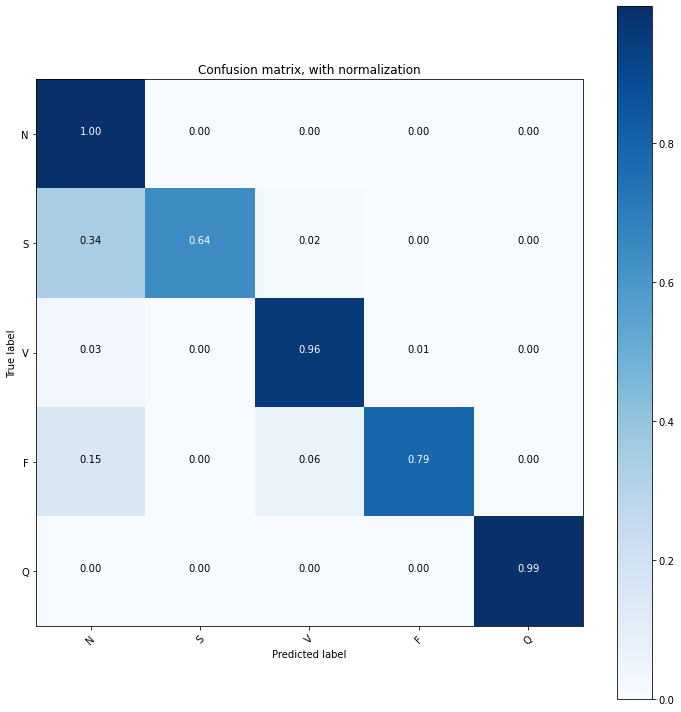

In [127]:
import itertools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()